In [2]:
import sys
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path to directory containing code of this case

In [3]:
new_path = r'/home/users/suihong/5-karstcave3D_Complete_cond_well_globalfeatures_probmap_Upload/' 
sys.path.append(new_path)

### 1. Import pre-trained Network

#### Set path to trained network

In [4]:
network_dir = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/110-pgan3D-4gpu-V100-OnlyCV-LC_8-GANw_2-NoLabelCond-CondWell_0.7-Enlarg-CondProb_1/'
network_name = 'network-snapshot-003360.pkl'

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)
    
del G

### 2. Import conditioning data from field measurements

#### 2.1 Well facies data

In [6]:
# Read field well data from file.
# In the file, the data are like following with I, J, K, well facies code (-99 means No well), cave probability value
# 1 1 1 -99.00 0.140967 
# 2 1 1 -99.00 0.148176 
# 3 1 1 -99.00 0.154223
#
#
welldata_path = '/scratch/users/suihong/CaveSimulation/PracticalDataFromTahe/TK6112_3D_well_prob'

allele=[] 
with open(welldata_path, 'r') as f:
    for line in f:
        eles = line.strip().split(' ')
        allele.append(eles)

allfiledata = np.array(allele, dtype = float).reshape((-1, 5))
print(allfiledata.shape)
welldata = allfiledata[:, 3].reshape((1, 1, 64, 64, 64)).transpose(0,1,3, 4, 2) # -99 means none, 0 means noncave, 1 means cave
welldata = welldata[:,:,::-1,:,::-1]
print(welldata.shape)

(262144, 5)
(1, 1, 64, 64, 64)


In [7]:
well_points = np.where(welldata == -99, 0, 1)
well_facies_types = np.where(welldata == -99, 0, welldata)
well_facies_input = np.concatenate([well_points, well_facies_types], 1)      
print(well_facies_input.shape)

(1, 2, 64, 64, 64)


In [8]:
### Enlarge area of each well occupies from 1x1 into 4 x 4 as inputs
###  following "mask" is only for better displaying in figures
well_facies_input = well_facies_input.astype(np.float32)
with tf.device('/gpu:0'):
    well_facies_input_enlarge = tf.nn.max_pool3d(well_facies_input, ksize = [1,1,4,4,4], strides=[1,1,1,1,1], padding='SAME', data_format='NCDHW') 

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    well_facies_input_el = sess.run(well_facies_input_enlarge)

# make mask of output well facies data 
well_facies_input_el_onechannel = well_facies_input_el[:,0:1]+well_facies_input_el[:,1:2]
well_facies_input_el_onechannel_mask = np.ma.masked_where(well_facies_input_el_onechannel == 0, well_facies_input_el_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

#### 2.2 Probability maps

In [9]:
from scipy import ndimage

probdata = allfiledata[:, 4].reshape((1, 1, 64, 64, 64)).transpose(0,1,3, 4, 2)
probdata = probdata[:,:,::-1,:,::-1]

print(probdata.shape)
probdata = np.where(probdata < 0.05, 0.05, probdata)

(1, 1, 64, 64, 64)


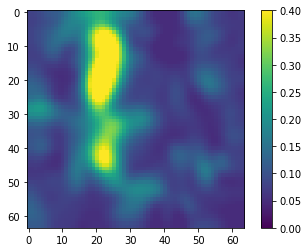

In [10]:
plt.imshow(probdata[0,0,:,:,30], vmin = 0, vmax = 0.4)
plt.colorbar()

### 3. Generating cave facies models using trained generator by taking the conditioning data as inputs

In [11]:
print(Gs.input_shapes)

[[None, 8, 4, 4, 4], [None, 0, 4, 4, 4], [None, 2, 64, 64, 64], [None, 1, 64, 64, 64]]


##### producing 400 random facies models

In [13]:
import time

start_time = time.time()

TotalReal_no_tk6112 = 400
condfakemodels_tk6112 = np.zeros([TotalReal_no_tk6112, 1, 64, 64, 64])
latents_tk6112 = np.random.RandomState(1315).randn(TotalReal_no_tk6112, 8, 4, 4, 4)
for i in range(int(TotalReal_no_tk6112/10)):
    latents_i_tk6112 = latents_tk6112[i*10:(i+1)*10]
    labels2_i_tk6112 = np.random.randn(10, 0, 4, 4, 4)  #.RandomState(816)
    well_facies_plt = np.repeat(well_facies_input_el, 10, axis=0)
    probcube_plt = np.repeat(probdata, 10, axis=0)  
    fakemodels_i = Gs.run(latents_i_tk6112, labels2_i_tk6112, well_facies_plt, probcube_plt)
    fakemodels_i = np.where(fakemodels_i< 0, -1, 1)
    condfakemodels_tk6112[i*10:(i+1)*10] = fakemodels_i

end_time = time.time()

time_each = (end_time - start_time)/400
print(time_each)

condfakemodels_tk6112_a = (condfakemodels_tk6112 + 1)/2
condfakemodels_tk6112_average = np.average(condfakemodels_tk6112_a, axis = 0)  # calcualte frequency map of cave facies, i.e., E-type

0.024746510982513428


##### Displaying horizontal slices of z = 32th cell from top

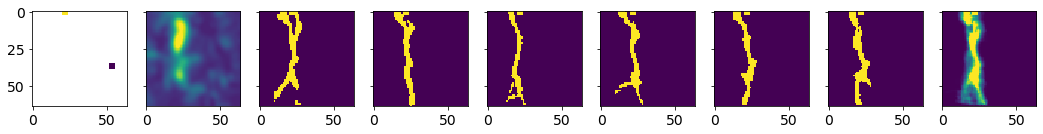

In [16]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 9, sharex='col', sharey='row')
fig.set_size_inches(18, 2, forward=True)

ax[0].imshow(well_facies_input_el_onechannel_mask[0,0,:,:,32], cmap=cmap_well, vmin=1, vmax=2)
ax[1].imshow(probdata[0,0,:,:,32], vmin = 0, vmax = 0.5)

for j in range(6):
    ax[j+2].imshow(condfakemodels_tk6112[j,0,:,:,28])
ax[8].imshow(condfakemodels_tk6112_average[0,:,:,28], vmin = 0, vmax = 0.5)   # E-type

#plt.savefig(network_dir + "simulations conditioned to practical well and prob_in TK6112_12.png", dpi=200) 

In [17]:
print(D.input_shape)

scores_all = np.zeros((400,1))
for i in range(100):
    scores = D.run(condfakemodels_tk6112[i*4:(i+1)*4])
    
    scores_all[i*4:(i+1)*4] = scores[0]

score_ind = np.argsort(scores_all.reshape(-1))

[None, 1, 64, 64, 64]


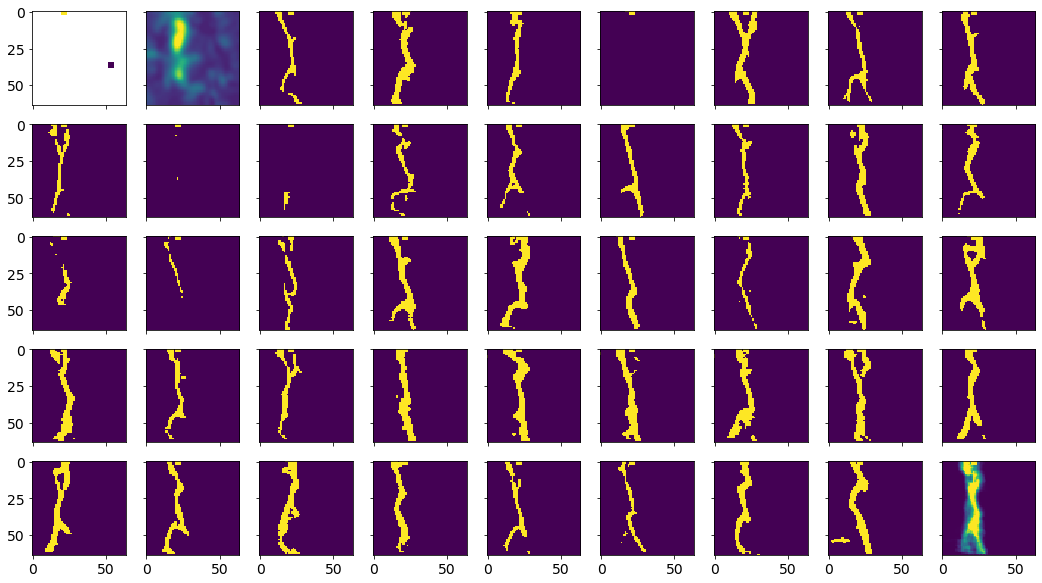

In [19]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(5, 9, sharex='col', sharey='row')
fig.set_size_inches(18, 10, forward=True)

ax[0, 0].imshow(well_facies_input_el_onechannel_mask[0,0,:,:,32], cmap=cmap_well, vmin=1, vmax=2)
ax[0, 1].imshow(probdata[0,0, :,:,32], vmin = 0, vmax = 0.5)

for j in range(7):
    ax[0, j+2].imshow(condfakemodels_tk6112[score_ind[369-j],0,:,:, 28])

for i in range(1, 5):
    for j in range(9):
        ax[i, j].imshow(condfakemodels_tk6112[score_ind[369-(7+(i-1)*9+j)],0,:,:,28])
        
ax[i, j].imshow(condfakemodels_tk6112_average[0,:,:,28], vmin = 0, vmax = 0.5)    
#plt.savefig(network_dir + "3Dsimulations conditioned to practical probdata_in TK6112_all_1.png", dpi=200) 

### 3.  Export generated realizations for displaying in Petrel software

##### Preparing index of I J K needed in the file

In [20]:
onecube = np.zeros([condfakemodels_tk6112.shape[4],condfakemodels_tk6112.shape[2],condfakemodels_tk6112.shape[3]])
print(onecube.shape)
coords = np.argwhere(onecube>-1)
print(coords.shape)
coords_output = np.zeros(coords.shape)
coords_output[:,0] = coords[:,2]+1
coords_output[:,1] = coords[:,1]+1
coords_output[:,2] = condfakemodels_tk6112.shape[4] - coords[:,0]
coords_output = coords_output.astype(np.int8)

(64, 64, 64)
(262144, 3)


In [21]:
print(condfakemodels_tk6112.shape)

(400, 1, 64, 64, 64)


##### Export realizations

In [22]:
print(condfakemodels_tk6112.shape)
condfakemodels_TK6112_output = condfakemodels_tk6112[score_ind[-31:-1]].transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
condfakemodels_TK6112_output = np.where(condfakemodels_TK6112_output>0,1,-99)
condfakemodels_TK6112_output_txt = np.concatenate((coords_output, condfakemodels_TK6112_output), axis = 1)
print(condfakemodels_TK6112_output_txt.shape)

(400, 1, 64, 64, 64)
(262144, 33)


In [25]:
condfakemodels_TK6112_fname = '/scratch/users/suihong/CaveSimulation/PracticalDataFromTahe/CondFakeFaciesModels_110_3360_TK6112.txt'
np.savetxt(condfakemodels_TK6112_fname, condfakemodels_TK6112_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

##### Export frequency map of cave

In [26]:
print(condfakemodels_tk6112_average.shape)
condfakemodels_tk6112_average_1 = np.expand_dims(condfakemodels_tk6112_average, axis=0)
condfakemodels_tk6112_average_output = condfakemodels_tk6112_average_1.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T
condfakemodels_tk6112_average_output_txt = np.concatenate((coords_output, condfakemodels_tk6112_average_output), axis = 1)
print(condfakemodels_tk6112_average_output_txt.shape)

(1, 64, 64, 64)
(262144, 4)


In [27]:
condfakemodels_tk6112_average_output_fname = '/scratch/users/suihong/CaveSimulation/PracticalDataFromTahe/CondFakeFaciesModels_110_3360_TK6112_av.txt'
np.savetxt(condfakemodels_tk6112_average_output_fname, condfakemodels_tk6112_average_output_txt, fmt='%i '*3 + "%3.2f ", newline='\n')   # "%03d" + "%.10f"*7

In [28]:
print(condfakemodels_tk6112_average.shape)

(1, 64, 64, 64)


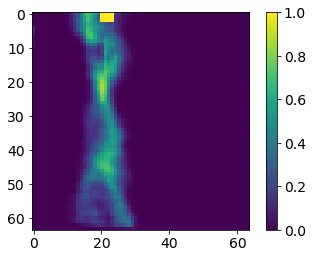

In [29]:
plt.imshow(condfakemodels_tk6112_average[0,:,:,30])
plt.colorbar()